# Trafic Signs Recognition

### Check if tensorflow will use GPU

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Import required packages

In [2]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import backend as K
# K.tensorflow_backend._get_available_gpus()
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

root_dir = 'GTSRB\\Final_Training\\Images\\'

print("finish step 1")

finish step 1


## Understand dataset

In [4]:
all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
print("Number singns in training set: {}".format(len(all_img_paths)))
number_of_classes = glob.glob(os.path.join(root_dir, '*/00000_00000.ppm'))
print("Number of classes: {}".format(len(number_of_classes)))

Number singns in training set: 39209
Number of classes: 43


Example sign from each class


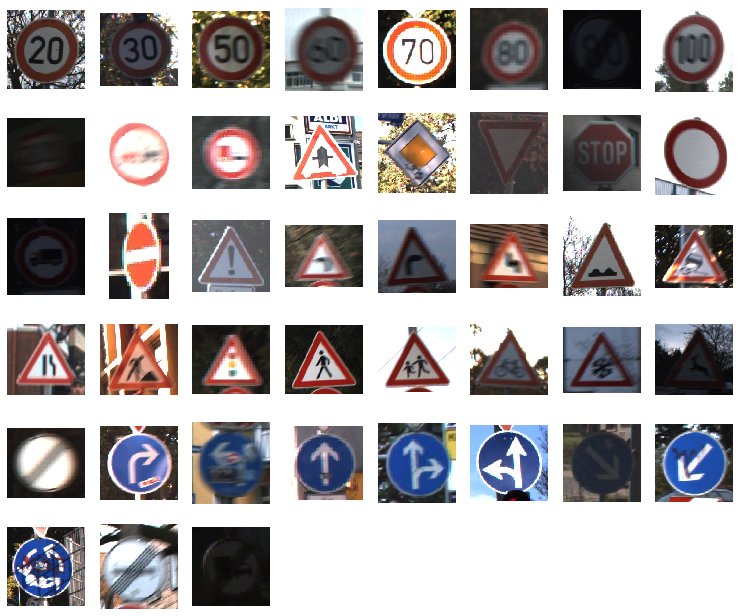

In [5]:
from matplotlib.pyplot import figure, imshow, axis, tight_layout
from matplotlib.image import imread

def showImagesInGrid(list_of_files):
    fig = figure(figsize=(13, 13))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files/7+1,8,i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

print("Example sign from each class")
image_from_each_class_paths = glob.glob(os.path.join(root_dir, '*/00002_00029.ppm'))
showImagesInGrid(image_from_each_class_paths)

Sample class trainig examples

Example signs from one class


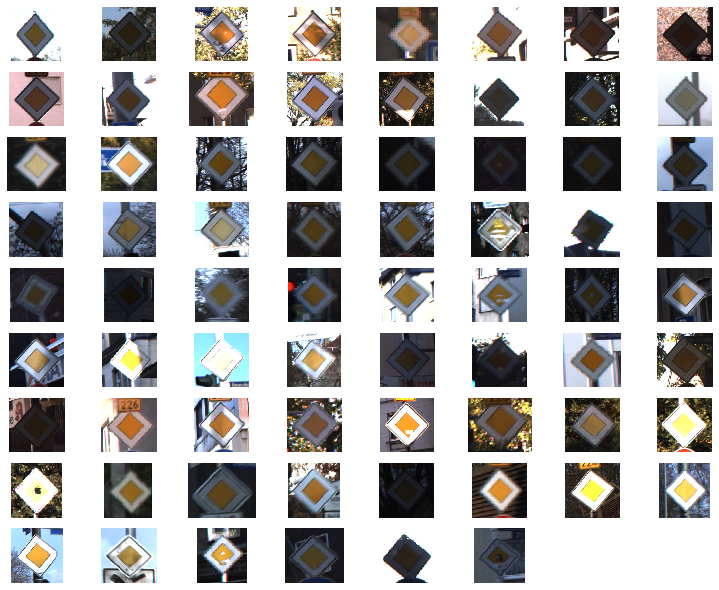

In [6]:
examples_from_class = 12

examples_from_one_class_path = '*0{}/*_00029.ppm'.format(examples_from_class)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

Each sign real life sign in dataset has already generated 30 variation of it 

Example signs from one class


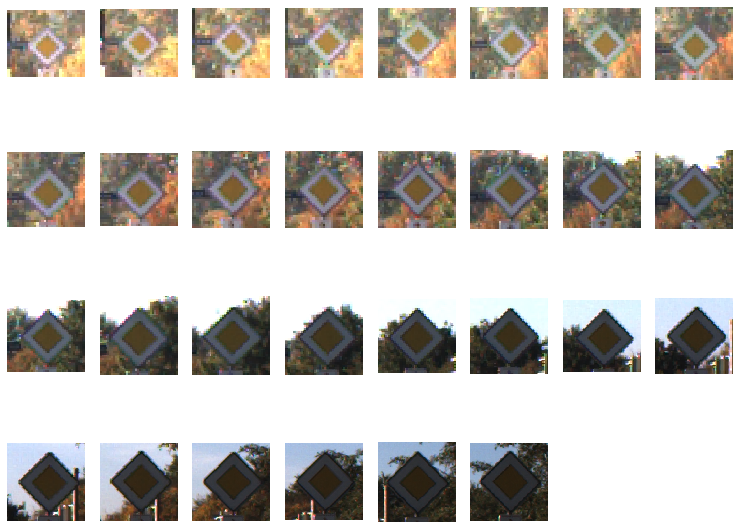

In [7]:
examples_from_class = 12
sign_no_varations = 1

examples_from_one_class_path = '*0{}/*0{}_*.ppm'.format(examples_from_class, sign_no_varations)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

## Function to preprocess the image:

In [11]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

#     central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('\\')[-2])
print("finish step 2")

finish step 2


Test image preprocessing functions below

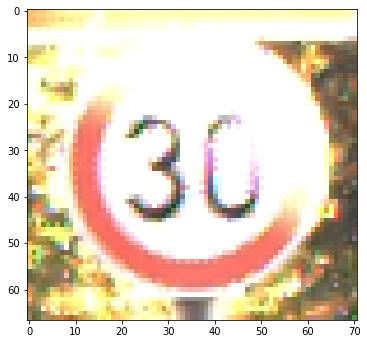

In [12]:
examples_from_one_class_path = '00001/00001_00029.ppm'
image_from_one_class_paths = os.path.join(root_dir, examples_from_one_class_path)

def showImagesInGridImages(list_of_files):
    fig = figure(figsize=(13, 13))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files/7+1,2,i+1)
#         image = imread(list_of_files[i])
        imshow(list_of_files[i])

images = []

images.append(io.imread(image_from_one_class_paths))
img = io.imread(image_from_one_class_paths)
# images.append(preprocess_img(img))

showImagesInGridImages(images)


## Preprocess all training images into a numpy array

In [13]:
try:
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

    print("finish step 3")
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")

Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209
finish step 3


# Define Keras model

In [3]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
# let's train the model using SGD + momentum.
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

print("finish step 4")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
finish step 4


# Start Training

In [15]:
batch_size = 32
nb_epoch = 30

model.fit(X, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True
          ,callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 24s 771us/sample - loss: 1.5609 - acc: 0.5616 - val_loss: 0.2272 - val_acc: 0.9342
Epoch 2/30
31367/31367 [==============================] - 15s 492us/sample - loss: 0.2520 - acc: 0.9239 - val_loss: 0.0816 - val_acc: 0.9733
Epoch 3/30
31367/31367 [==============================] - 15s 493us/sample - loss: 0.1485 - acc: 0.9533 - val_loss: 0.0461 - val_acc: 0.9852
Epoch 4/30
31367/31367 [==============================] - 16s 495us/sample - loss: 0.1049 - acc: 0.9680 - val_loss: 0.0384 - val_acc: 0.9902ss: 0.1050 - acc: 0.967 - ETA: 0s - loss: 0.1047 - acc: 0.968
Epoch 5/30
31367/31367 [==============================] - 16s 495us/sample - loss: 0.0837 - acc: 0.9758 - val_loss: 0.0316 - val_acc: 0.9911
Epoch 6/30
31367/31367 [==============================] - 16s 500us/sample - loss: 0.0674 - acc: 0.9792 - val_loss: 0.0307 - val_acc: 0.9912: 0.0670 - acc: 0.979 - ETA: 3s - loss: - ETA

# Load Test data

In [1]:
import pandas as pd
test = pd.read_csv('GT-final_test.csv',sep=';')

X_test = []
y_test = []
i = 0
print("list lenght {})".format(len(list(test['Filename']))))
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB\\Final_Test\\Images\\',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    if len(X_test)%10 == 0: print("Processed {}/{}".format(len(X_test), len(y_test)))
    
    
X_test = np.array(X_test)
y_test = np.array(y_test)

list lenght 12630)


NameError: name 'os' is not defined

In [ ]:
y_pred = model.predict_classes(X_test)
print(y_pred)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 23, 23)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 10, 10)        0

In [5]:
model.count_params()

1358155